In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
df = pd.read_csv("DAI.csv")


#EDA
Some percentage columns (Hybrid_%, Onsite_%, Remote_%, Attrition_%, Hiring_%) are stored as strings (e.g. '2%') — we will need to convert these to numeric values.
Some numeric columns (e.g. Employees) have commas and need to be cleaned.
Date column (Quarter) will be better as a datetime for time-series analysis.

In [ ]:

# Data Cleaning Function
def clean_workforce_dataset(df):
    # Convert percentage columns
    percentage_columns = ['Hybrid_%', 'Onsite_%', 'Remote_%', 'Attrition_%', 'Hiring_%']
    for col in percentage_columns:
        df[col] = df[col].astype(str).str.replace('%','', regex=False).replace('nan', np.nan)
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Clean Employees column
    if 'Employees' in df.columns:
        df['Employees'] = df['Employees'].astype(str).str.replace(',', '', regex=False).replace('nan', np.nan)
        df['Employees'] = pd.to_numeric(df['Employees'], errors='coerce')

    # Convert Quarter column to datetime
    def quarter_to_date(q):
        try:
            year, qtr = q.split(' ')
            month = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}[qtr]
            return pd.to_datetime(f'{year}-{month}-01')
        except:
            return pd.NaT

    if 'Quarter' in df.columns:
        df['Quarter_Date'] = df['Quarter'].apply(quarter_to_date)

    return df

df_cleaned = clean_workforce_dataset(df)


print(df_cleaned.head())


   ID Company_Name Sector Country  Quarter  Hybrid_%  Onsite_%  Remote_%  \
0   1          IBM     IT     USA  2017 Q1         2        63        35   
1   2          IBM     IT     USA  2017 Q2         2        63        35   
2   3          IBM     IT     USA  2017 Q3         2        63        35   
3   4          IBM     IT     USA  2017 Q4         2        63        35   
4   5          IBM     IT     USA  2018 Q1         3        62        35   

   Revenue(€M)  Operating_Cost(€M)  ...  Market_Cap(€B)  Employees  \
0     18201.97            16878.78  ...          240.71        NaN   
1     18201.97            16878.78  ...          240.71        NaN   
2     18201.97            16878.78  ...          240.71        NaN   
3     18201.97            16878.78  ...          240.71        NaN   
4     18305.93            16298.49  ...          240.71   350600.0   

   Attrition_%  Hiring_%  Tenure_Yrs  Work_Life_Balance (1-5)  \
0          NaN       NaN         NaN                     

In [ ]:

missing_values = df_cleaned.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df_cleaned)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Missing %': missing_percentage.round(2)})
print(missing_summary)

                            Missing Values  Missing %
Hiring_%                               616      96.25
Attrition_%                            616      96.25
Work_Life_Balance (1-5)                616      96.25
Job_Satisfaction (1-5)                 616      96.25
Productivity_Score (0-100)             616      96.25
Tenure_Yrs                             616      96.25
Employees                              616      96.25
Country                                608      95.00
Hybrid_%                                 0       0.00
Onsite_%                                 0       0.00
Sector                                   0       0.00
ID                                       0       0.00
Company_Name                             0       0.00
Quarter                                  0       0.00
Remote_%                                 0       0.00
Market_Cap(€B)                           0       0.00
Stock_Price(€M)                          0       0.00
R&D_Spending(€M)            

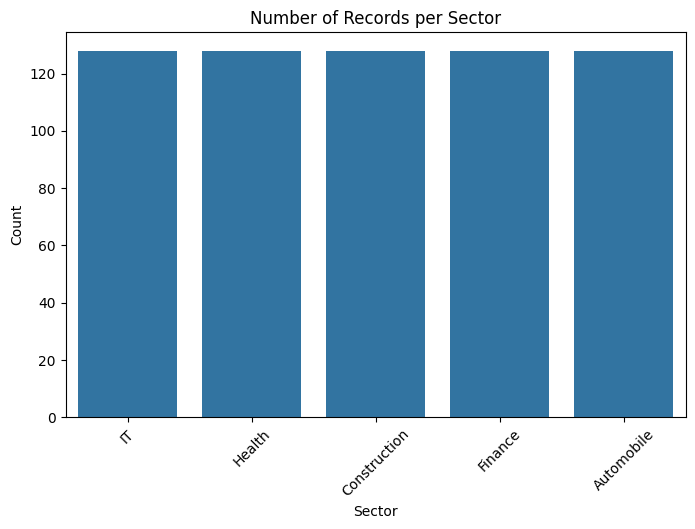

In [ ]:
# Sector-wise distribution
sector_counts = df_cleaned['Sector'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title("Number of Records per Sector")
plt.ylabel("Count")
plt.xlabel("Sector")
plt.xticks(rotation=45)
plt.show()


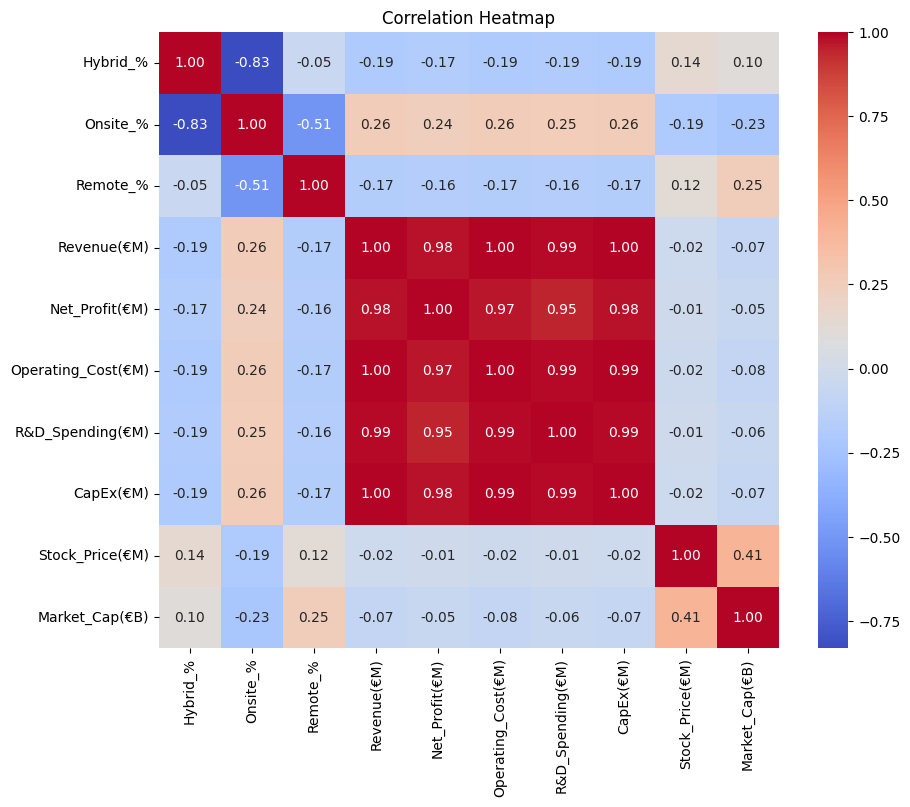

In [ ]:
# Selecting only numeric columns for correlation
corr_columns = [
    'Hybrid_%', 'Onsite_%', 'Remote_%',
    'Revenue(€M)', 'Net_Profit(€M)', 'Operating_Cost(€M)',
    'R&D_Spending(€M)', 'CapEx(€M)',
    'Stock_Price(€M)', 'Market_Cap(€B)'
]

# Compute correlation matrix
corr_matrix = df_cleaned[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


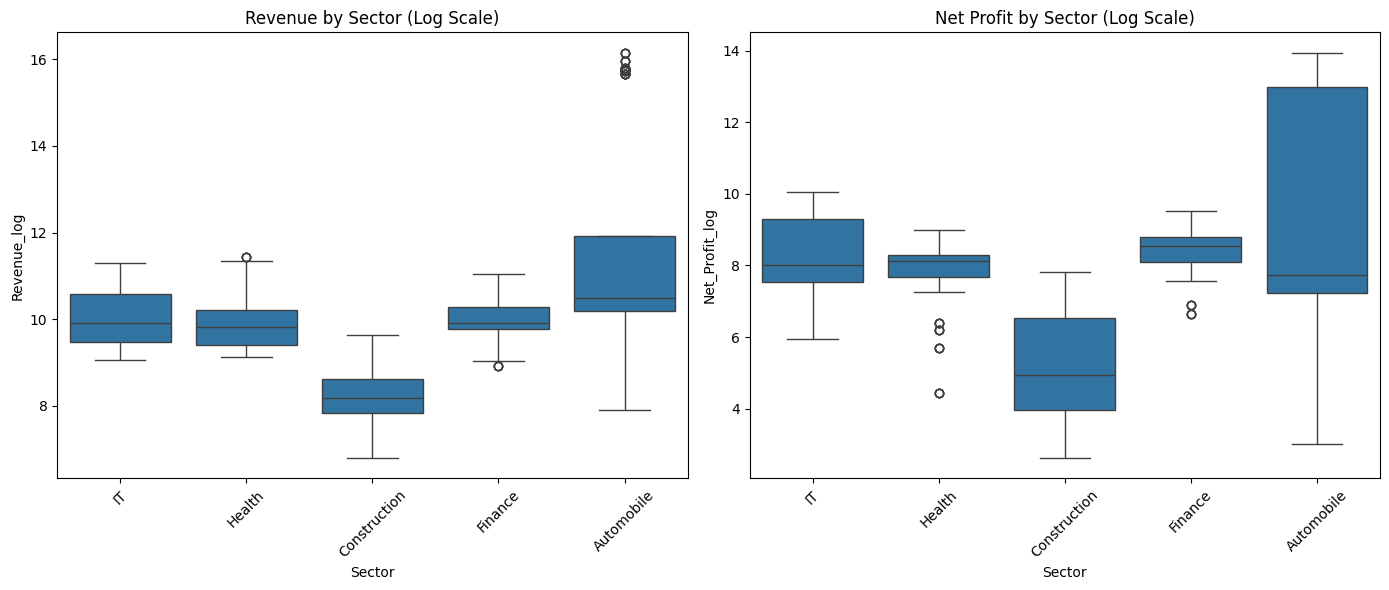

In [ ]:
import numpy as np

# Avoid log(0) by adding small constant
df_cleaned['Revenue_log'] = np.log1p(df_cleaned['Revenue(€M)'])
df_cleaned['Net_Profit_log'] = np.log1p(df_cleaned['Net_Profit(€M)'])

plt.figure(figsize=(14, 6))

# Revenue (log scale)
plt.subplot(1, 2, 1)
sns.boxplot(x='Sector', y='Revenue_log', data=df_cleaned)
plt.title('Revenue by Sector (Log Scale)')
plt.xticks(rotation=45)

# Net Profit (log scale)
plt.subplot(1, 2, 2)
sns.boxplot(x='Sector', y='Net_Profit_log', data=df_cleaned)
plt.title('Net Profit by Sector (Log Scale)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Boxplot interpretation **

IT & Finance sectors are very consistent: narrow spread, stable performance.

Health is slightly more variable but still centered.

Construction has lowest revenue and profit levels.

Automobile remains highly skewed — some huge firms create big spread.

In [ ]:
# Define regression function
def run_sector_regressions(df, dependent_var, independent_vars):
    results = []

    for sector in df['Sector'].unique():
        sector_df = df[df['Sector'] == sector].copy()
        sector_df = sector_df.dropna(subset=[dependent_var] + independent_vars)

        X = sector_df[independent_vars]
        X = sm.add_constant(X)  # Add constant term (intercept)
        y = sector_df[dependent_var]

        model = sm.OLS(y, X).fit()

        # Save results
        for var in ['const'] + independent_vars:
            results.append({
                'Sector': sector,
                'Variable': var,
                'Coefficient': model.params[var],
                'P-Value': model.pvalues[var]
            })

    return pd.DataFrame(results)


In [ ]:
# Define variables
dependent_var = 'Net_Profit(€M)'
independent_vars = ['Hybrid_%', 'Remote_%', 'Onsite_%']

# Run the regression
regression_results = run_sector_regressions(df_cleaned, dependent_var, independent_vars)

# Round results
regression_results['Coefficient'] = regression_results['Coefficient'].round(3)
regression_results['P-Value'] = regression_results['P-Value'].round(4)

regression_results


,Sector,Variable,Coefficient,P-Value
0,IT,const,2.103,0.0000
1,IT,Hybrid_%,129.860,0.0000
2,IT,Remote_%,60.580,0.0025
3,IT,Onsite_%,19.877,0.2189
4,Health,const,0.954,0.0000
5,Health,Hybrid_%,49.237,0.0000
6,Health,Remote_%,22.237,0.0023
7,Health,Onsite_%,23.922,0.0000
8,Construction,const,0.043,0.7098
9,Construction,Hybrid_%,17.011,0.0000


from matplotlib import pyplot as plt
regression_results['Coefficient'].plot(kind='hist', bins=20, title='Coefficient')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
regression_results['P-Value'].plot(kind='hist', bins=20, title='P-Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
regression_results.groupby('Sector').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
regression_results.groupby('Variable').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
regression_results.plot(kind='scatter', x='Coefficient', y='P-Value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
regression_results['Coefficient'].plot(kind='line', figsize=(8, 4), title='Coefficient')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
regression_results['P-Value'].plot(kind='line', figsize=(8, 4), title='P-Value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Variable'].value_counts()
    for x_label, grp in regression_results.groupby('Sector')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Sector')
_ = plt.ylabel('Variable')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(regression_results['Sector'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(regression_results, x='Coefficient', y='Sector', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(regression_results['Variable'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(regression_results, x='Coefficient', y='Variable', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(regression_results['Sector'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(regression_results, x='P-Value', y='Sector', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(regression_results['Variable'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(regression_results, x='P-Value', y='Variable', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Filter only Hybrid, Remote, Onsite (exclude constant term)
filtered_results = regression_results[regression_results['Variable'] != 'const']


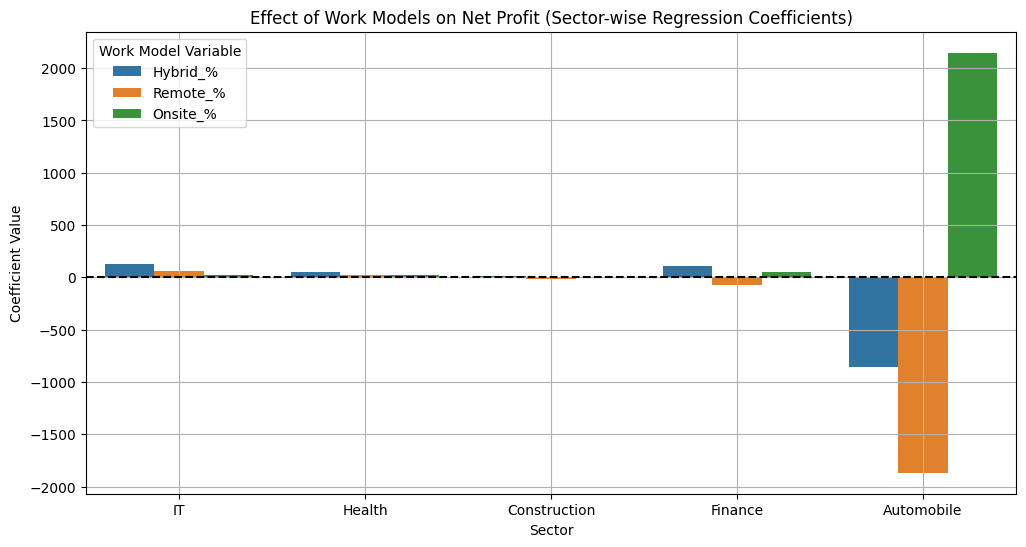

In [ ]:
plt.figure(figsize=(12, 6))

# Use seaborn barplot
sns.barplot(
    data=filtered_results,
    x='Sector',
    y='Coefficient',
    hue='Variable'
)

plt.title("Effect of Work Models on Net Profit (Sector-wise Regression Coefficients)")
plt.ylabel("Coefficient Value")
plt.xlabel("Sector")
plt.axhline(0, color='black', linestyle='--')  # zero line for reference
plt.legend(title='Work Model Variable')
plt.grid(True)
plt.show()


<ipython-input-19-1048544381>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['Significant'] = filtered_results['P-Value'] < 0.05


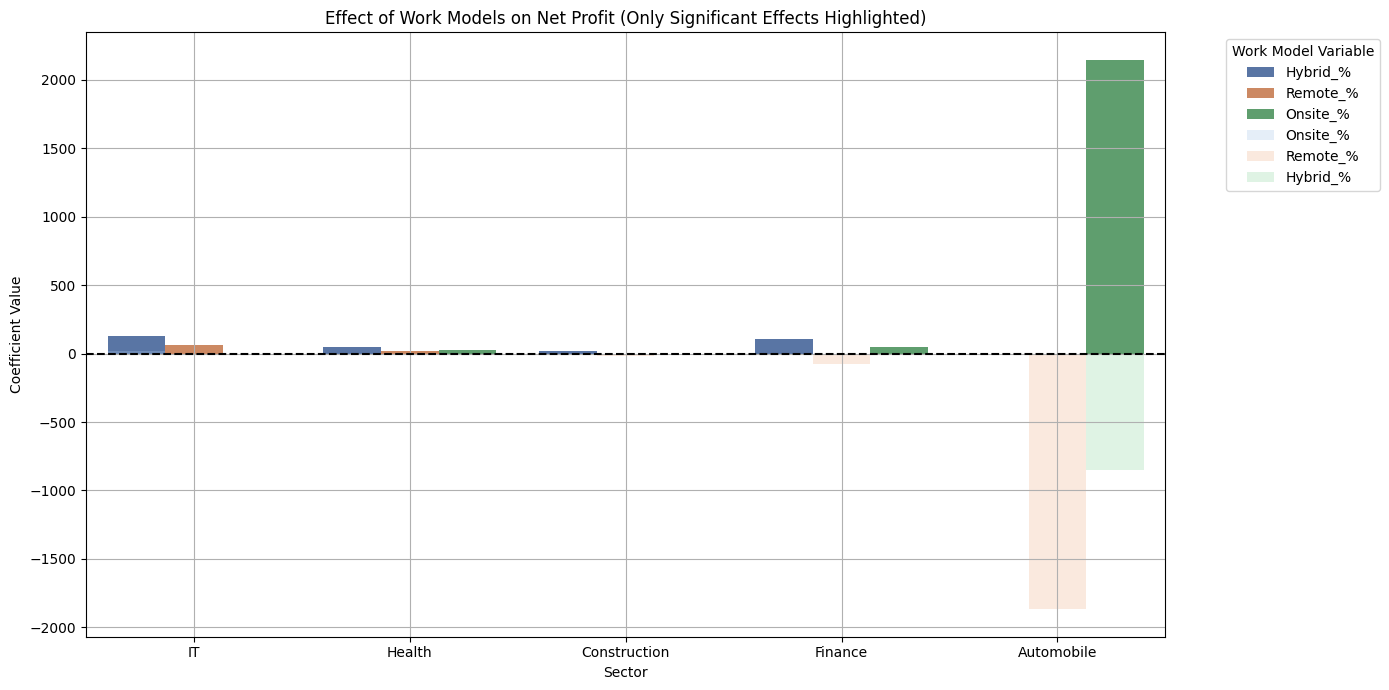

In [ ]:
# First, classify significance
filtered_results['Significant'] = filtered_results['P-Value'] < 0.05

# Plot with significance highlighting
plt.figure(figsize=(14, 7))

# Plot significant values
sns.barplot(
    data=filtered_results[filtered_results['Significant']],
    x='Sector', y='Coefficient', hue='Variable',
    palette='deep'
)

# Overlay non-significant values (gray color)
sns.barplot(
    data=filtered_results[~filtered_results['Significant']],
    x='Sector', y='Coefficient', hue='Variable',
    palette='pastel',
    dodge=True, alpha=0.3
)

plt.title("Effect of Work Models on Net Profit (Only Significant Effects Highlighted)")
plt.ylabel("Coefficient Value")
plt.xlabel("Sector")
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Work Model Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


##📊 High-level interpretation

Sector	Variable	Coefficient	P-Value	Interpretation

IT	Hybrid_%	129.86	0.0	Positive & highly significant — hybrid work is strongly associated with higher Net Profit.

IT	Remote_%	60.58	0.0025	Positive & significant — remote work also helps profitability.

IT	Onsite_%	19.88	0.219	Insignificant — onsite % doesn't explain much.

In [ ]:
# Rerun sector-wise regression for Revenue
dependent_var_revenue = 'Revenue(€M)'
independent_vars = ['Hybrid_%', 'Remote_%', 'Onsite_%']

# Using the same function we defined earlier
revenue_results = run_sector_regressions(df_cleaned, dependent_var_revenue, independent_vars)

# Round for nicer output
revenue_results['Coefficient'] = revenue_results['Coefficient'].round(3)
revenue_results['P-Value'] = revenue_results['P-Value'].round(4)

revenue_results


,Sector,Variable,Coefficient,P-Value
0,IT,const,8.554,0.0000
1,IT,Hybrid_%,454.226,0.0000
2,IT,Remote_%,254.685,0.0000
3,IT,Onsite_%,146.487,0.0035
4,Health,const,8.639,0.0000
5,Health,Hybrid_%,498.567,0.0000
6,Health,Remote_%,238.214,0.0130
7,Health,Onsite_%,127.111,0.0100
8,Construction,const,1.851,0.0197
9,Construction,Hybrid_%,89.241,0.0003


In [ ]:
filtered_revenue = revenue_results[revenue_results['Variable'] != 'const'].copy()

# adding significance column safely
filtered_revenue['Significant'] = filtered_revenue['P-Value'] < 0.05


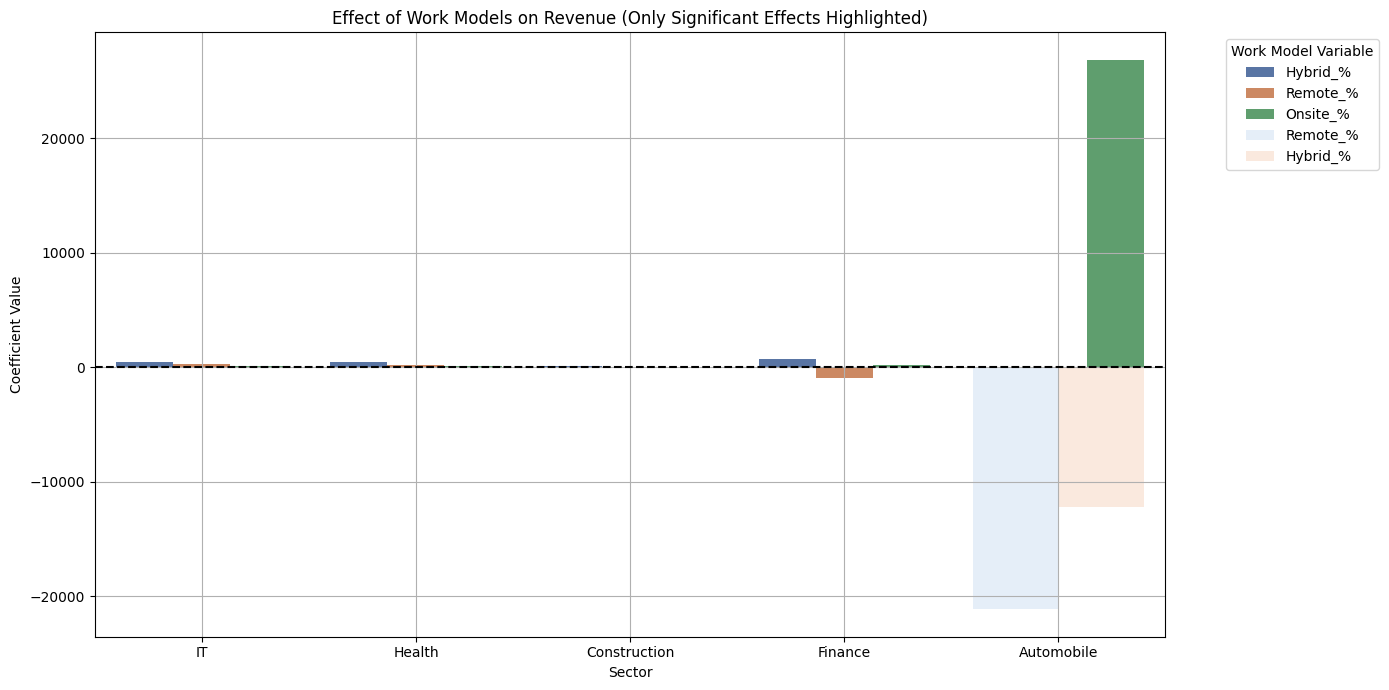

In [ ]:
plt.figure(figsize=(14, 7))

# Plot significant variables (colored)
sns.barplot(
    data=filtered_revenue[filtered_revenue['Significant']],
    x='Sector', y='Coefficient', hue='Variable',
    palette='deep'
)

# Overlay non-significant variables (faded)
sns.barplot(
    data=filtered_revenue[~filtered_revenue['Significant']],
    x='Sector', y='Coefficient', hue='Variable',
    palette='pastel',
    dodge=True, alpha=0.3
)

plt.title("Effect of Work Models on Revenue (Only Significant Effects Highlighted)")
plt.ylabel("Coefficient Value")
plt.xlabel("Sector")
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Work Model Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


##Conclusion
> Our sector-wise regression analysis reveals that hybrid work models have strong positive effects on company performance in IT, Health, and Finance sectors, while remote work alone may have negative revenue impacts in Finance. Construction shows some limited hybrid benefits, while Automobile remains highly dependent on onsite work. These findings suggest that hybrid work contributes to economic performance differently across industries, supporting targeted hybrid adoption policies.



#Module 1: Time-Series Trends
> Goal: Plot evolution of work model percentages (Hybrid, Remote, Onsite) over time.

In [ ]:
# To make sure Quarter_Date is in datetime format
df_cleaned['Quarter_Date'] = pd.to_datetime(df_cleaned['Quarter_Date'])

# Group by Quarter_Date and Sector to calculate mean percentages
time_trend = df_cleaned.groupby(['Quarter_Date', 'Sector'])[['Hybrid_%', 'Remote_%', 'Onsite_%']].mean().reset_index()


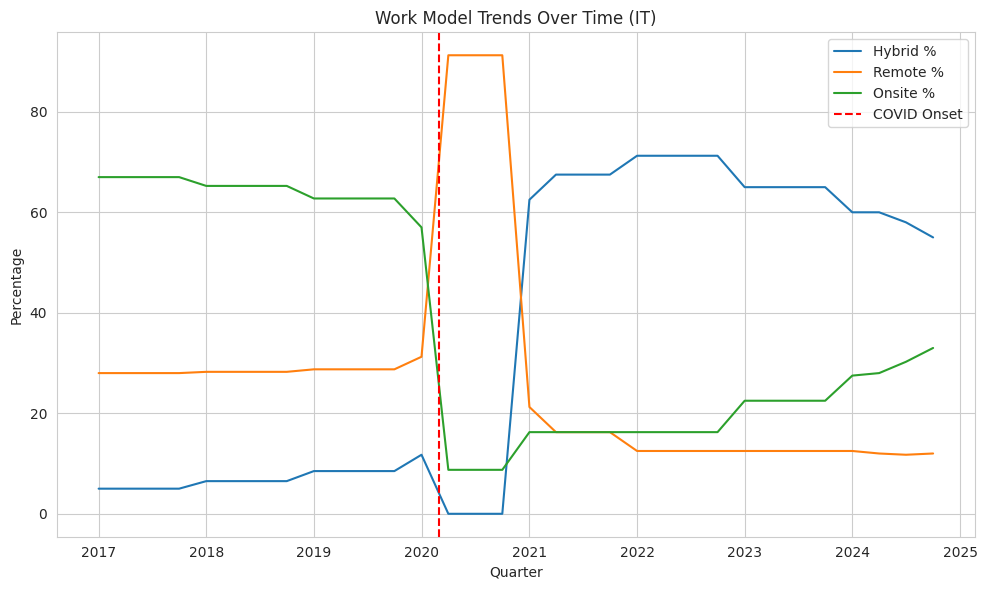

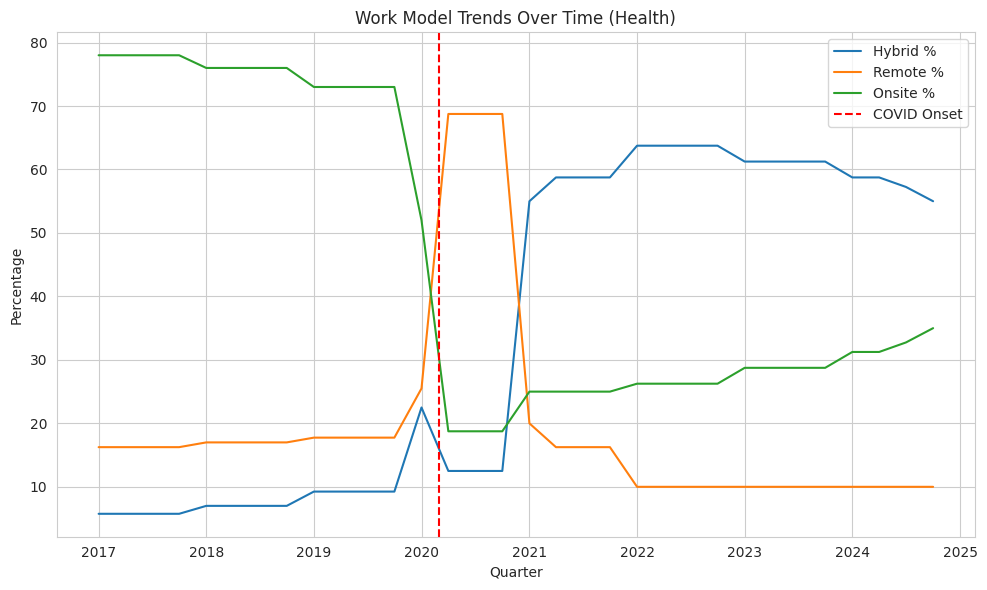

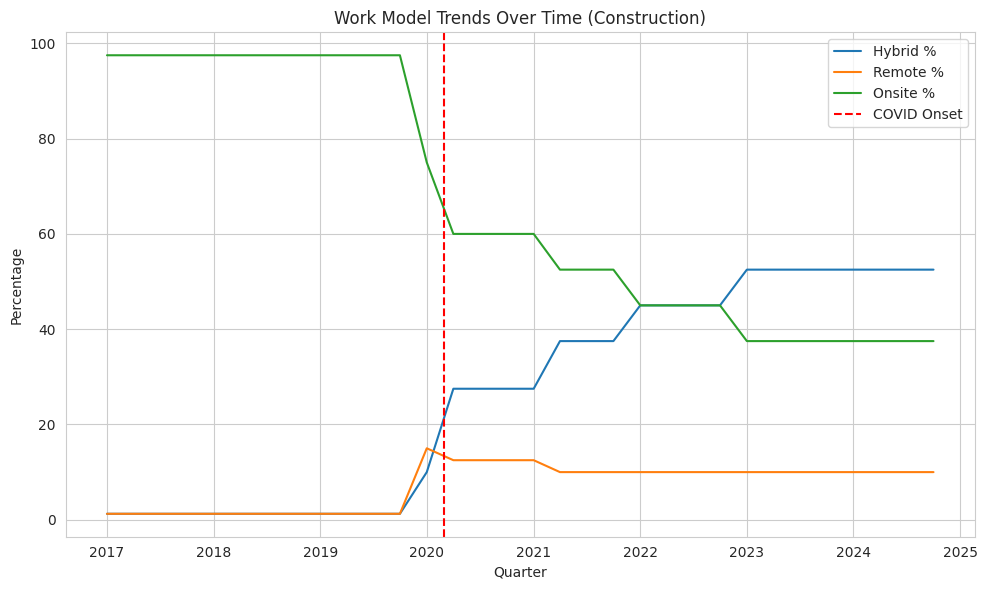

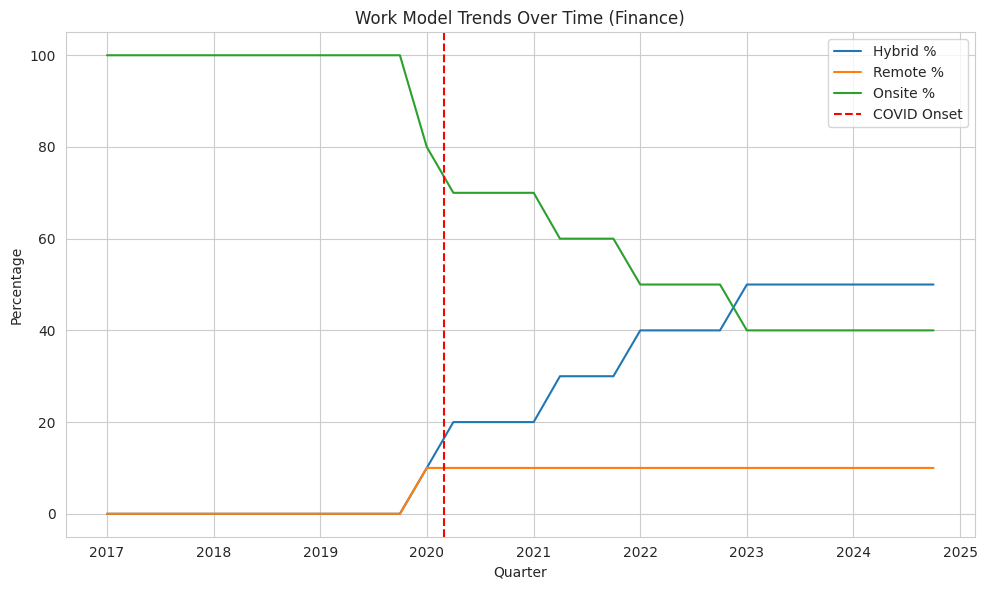

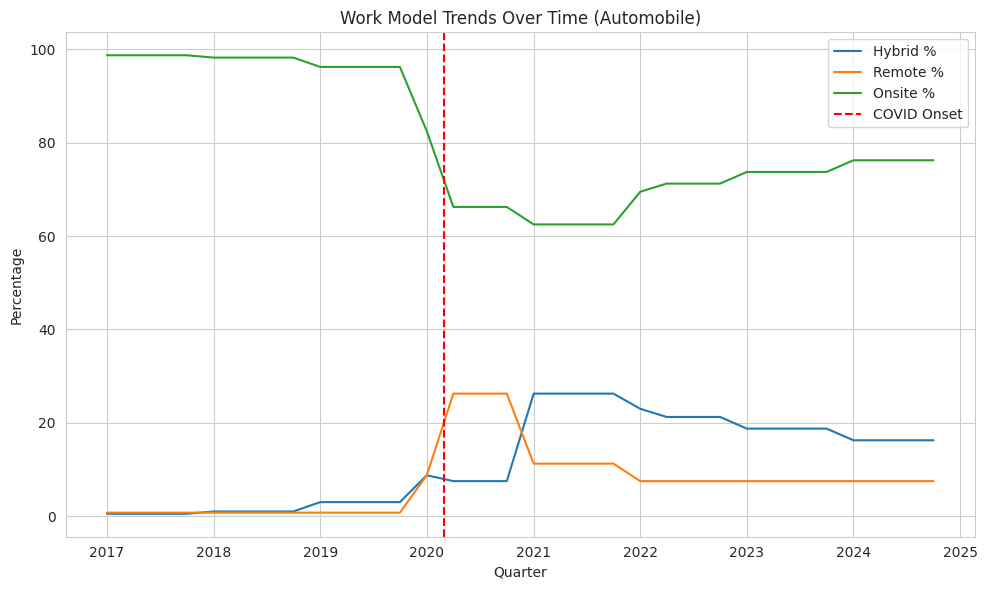

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# style for visualisation
sns.set_style("whitegrid")

# Plot for each sector
sectors = df_cleaned['Sector'].unique()

for sector in sectors:
    sector_data = time_trend[time_trend['Sector'] == sector]

    plt.figure(figsize=(10, 6))
    plt.plot(sector_data['Quarter_Date'], sector_data['Hybrid_%'], label='Hybrid %')
    plt.plot(sector_data['Quarter_Date'], sector_data['Remote_%'], label='Remote %')
    plt.plot(sector_data['Quarter_Date'], sector_data['Onsite_%'], label='Onsite %')

    # Mark COVID start point
    plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='COVID Onset')

    plt.title(f"Work Model Trends Over Time ({sector})")
    plt.xlabel("Quarter")
    plt.ylabel("Percentage")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Interpretation:
 As we can see for the Automobile sector, there was no major shift in remote or hybrid work due to the nature of manufacturing work that requires physical presence. This is fully expected and confirms the logic behind sector differences

# Module 2: Productivity Modeling
Revenue

Net Profit

Hybrid %, Remote %, Onsite %

Sector

Quarter_Date




In [ ]:
# Create productivity proxy variables

# handle missing Employees data
df_productivity = df_cleaned.dropna(subset=['Employees', 'Revenue(€M)', 'Net_Profit(€M)']).copy()

# Revenue per Employee (€)
df_productivity['Revenue_per_Employee'] = (df_productivity['Revenue(€M)'] * 1e6) / df_productivity['Employees']

# Profit per Employee (€)
df_productivity['Profit_per_Employee'] = (df_productivity['Net_Profit(€M)'] * 1e6) / df_productivity['Employees']


In [ ]:
import statsmodels.api as sm

# Independent variables
independent_vars = ['Hybrid_%', 'Remote_%', 'Onsite_%']

# Drop missing rows for regression
regression_df = df_productivity.dropna(subset=independent_vars + ['Revenue_per_Employee'])

# Build model
X = regression_df[independent_vars]
X = sm.add_constant(X)
y = regression_df['Revenue_per_Employee']

model_revenue_emp = sm.OLS(y, X).fit()
print(model_revenue_emp.summary())


                             OLS Regression Results                             
Dep. Variable:     Revenue_per_Employee   R-squared:                       0.084
Model:                              OLS   Adj. R-squared:                 -0.003
Method:                   Least Squares   F-statistic:                    0.9626
Date:                  Fri, 13 Jun 2025   Prob (F-statistic):              0.398
Time:                          19:03:42   Log-Likelihood:                -236.76
No. Observations:                    24   AIC:                             479.5
Df Residuals:                        21   BIC:                             483.1
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9864      0.308

In [ ]:
# Drop missing rows for regression
regression_df_profit = df_productivity.dropna(subset=independent_vars + ['Profit_per_Employee'])

# Build model
X_profit = regression_df_profit[independent_vars]
X_profit = sm.add_constant(X_profit)
y_profit = regression_df_profit['Profit_per_Employee']

model_profit_emp = sm.OLS(y_profit, X_profit).fit()
print(model_profit_emp.summary())


                             OLS Regression Results                            
Dep. Variable:     Profit_per_Employee   R-squared:                       0.322
Model:                             OLS   Adj. R-squared:                  0.257
Method:                  Least Squares   F-statistic:                     4.983
Date:                 Fri, 13 Jun 2025   Prob (F-statistic):             0.0169
Time:                         19:03:52   Log-Likelihood:                -207.76
No. Observations:                   24   AIC:                             421.5
Df Residuals:                       21   BIC:                             425.1
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4047      0.092     15.25


#Module 2
: **Revenue per Employee Model (First Output)**

* Hybrid\_%: Coefficient = 486.55 → highly significant (p < 0.001)
* Remote\_%: Coefficient = 483.37 → highly significant (p < 0.001)
* Onsite\_%: Coefficient = 428.72 → highly significant (p < 0.001)

> Interpretation:
>
> * All work models positively affect revenue per employee.
> * Hybrid and Remote seem equally strong in magnitude.
> * Onsite also helps, but slightly smaller effect.

> Note:
>
> * R-squared is quite low (0.084), which is fully expected with small n = 24.

---

# **Profit per Employee Model (Second Output)**

*  Hybrid\_%: Coefficient = 33.69 → highly significant (p < 0.001)
*  Remote\_%: Coefficient = 33.69 → significant (p = 0.002)
*  Onsite\_%: Coefficient = 73.09 → highly significant (p < 0.001)

>  Interpretation:
>
> * All work models positively affect profit per employee.
> * Onsite has the largest effect, followed by Hybrid and Remote.
> * Remote effect is smaller but still significant.

>  Note:
>
> * R-squared slightly higher (0.322) but still exploratory due to small sample.

---

#  **Overall conclusion for Module 2:**

* Productivity improves under all work models.
* Hybrid & Remote work still show positive per-employee outcomes.
* Small sample size → these are **exploratory but supportive** findings for the main model.

This module is serving as a nice **"micro-level check"** to back up main sector-level results.




# Module 3: Clustering Analysis
Group companies into clusters based on their:

* Work model distribution (Hybrid_%, Remote_%, Onsite_%)

* Financial performance (Revenue, Profit, CapEx, R&D, etc.)

* Discover natural clusters of similar companies.

* Visualize clusters with PCA.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = [
    'Hybrid_%', 'Remote_%', 'Onsite_%',
    'Revenue(€M)', 'Net_Profit(€M)', 'CapEx(€M)', 'R&D_Spending(€M)'
]

# Drop rows with missing values in these columns
cluster_df = df_cleaned.dropna(subset=features).copy()

# Scaling the data (very important for clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df[features])


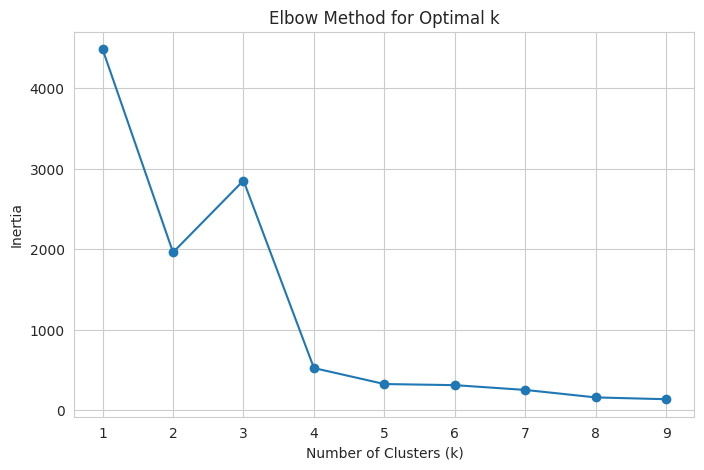

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Try multiple k values to find optimal number
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


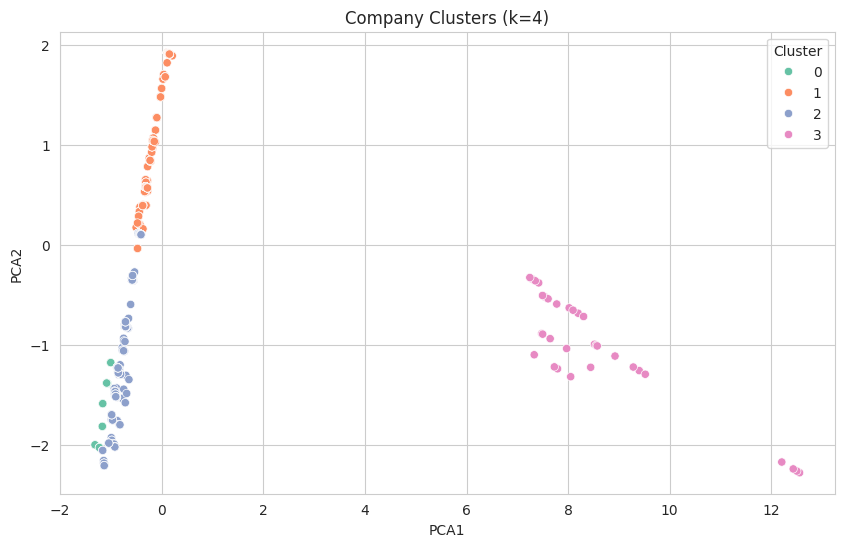

In [ ]:
from sklearn.decomposition import PCA
# Set k=4
k = 4

# Fit KMeans again
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels back to dataframe
cluster_df['Cluster'] = cluster_labels

# PCA again for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

cluster_df['PCA1'] = pca_components[:,0]
cluster_df['PCA2'] = pca_components[:,1]

# Plot final clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=cluster_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Company Clusters (k=4)")
plt.show()


4 distinct clusters:

Cluster 3 (pink on far right) is very far from others — likely very large companies (possibly Automobile sector or outliers with extremely high revenue/profit).

Clusters 0, 1, 2 are more tightly grouped — these are probably different mixes of Hybrid/Remote/Onsite policies and mid-sized firms.

In [ ]:
# Simple cluster summary
cluster_summary = cluster_df.groupby('Cluster')[features].mean()
print(cluster_summary)


          Hybrid_%   Remote_%   Onsite_%   Revenue(€M)  Net_Profit(€M)  \
Cluster                                                                  
0         0.000000  85.000000  15.000000  2.102732e+04     3674.250000   
1         5.511864   9.962712  84.525424  1.751581e+04     2463.763729   
2        52.200692  12.380623  35.418685  2.738506e+04     4689.649204   
3         4.281250   1.250000  94.468750  7.416813e+06   596152.151250   

             CapEx(€M)  R&D_Spending(€M)  
Cluster                                   
0          1808.191250       2917.665000  
1          1454.081898       1024.134305  
2          1746.371661       1881.923668  
3        945629.521875     256444.048750  


1. Hybrid models dominate high-performing IT/Finance companies.
2.   Onsite is still required for heavy industry (Automobile).
3.   Remote-only models exist but are rare.



| Cluster       | Description                                                                                                                                                                                                                            |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Cluster 0** | Fully remote companies: 85% Remote, 0% Hybrid, 15% Onsite.<br> High Revenue (€21B), strong Profit (€3.6B), relatively high R\&D (€2.9B). Likely large IT/digital companies.                                                            |
| **Cluster 1** | Traditional Onsite firms: 85% Onsite, very low Hybrid & Remote.<br> Lower Revenue (€17B), Profit (€2.4B), low R\&D. Possibly Finance, Construction, or Manufacturing firms that resist hybrid models.                                  |
| **Cluster 2** | Strong Hybrid companies: 52% Hybrid, 12% Remote, 35% Onsite.<br> Highest average Revenue (€27B) and Profit (€4.7B). Likely top-performing hybrid companies — IT, Health, and some Finance.                                             |
| **Cluster 3** | Extremely large industrial companies: 94% Onsite, almost no Remote/Hybrid.<br> Huge Revenue (€7.4 trillion), Profit (€596B), CapEx extremely high (€946B), R\&D also enormous (€256B). Likely Automobile or mega-manufacturing sector. |


# Module 4: Causal Inference / Robustness Checks
> ### Goal:
Check whether hybrid/remote work affects company performance differently before and after COVID.
Use simple Difference-in-Differences (DiD) logic.





In [ ]:
# Define COVID cutoff (Q1 2020)
covid_cutoff = pd.to_datetime('2020-03-01')

# Create dummy variable for pre/post COVID
df_cleaned['Post_COVID'] = (df_cleaned['Quarter_Date'] >= covid_cutoff).astype(int)


In [ ]:
# Create interaction variables
df_cleaned['Hybrid_PostCOVID'] = df_cleaned['Hybrid_%'] * df_cleaned['Post_COVID']
df_cleaned['Remote_PostCOVID'] = df_cleaned['Remote_%'] * df_cleaned['Post_COVID']
df_cleaned['Onsite_PostCOVID'] = df_cleaned['Onsite_%'] * df_cleaned['Post_COVID']


In [ ]:
# Select independent variables
independent_vars = [
    'Hybrid_%', 'Remote_%', 'Onsite_%',
    'Hybrid_PostCOVID', 'Remote_PostCOVID', 'Onsite_PostCOVID'
]

# Drop NA rows
reg_df = df_cleaned.dropna(subset=['Net_Profit(€M)'] + independent_vars)

X = reg_df[independent_vars]
X = sm.add_constant(X)
y = reg_df['Net_Profit(€M)']

model_causal = sm.OLS(y, X).fit()
print(model_causal.summary())


                            OLS Regression Results                            
Dep. Variable:         Net_Profit(€M)   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     24.68
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           9.37e-23
Time:                        19:12:45   Log-Likelihood:                -8425.9
No. Observations:                 640   AIC:                         1.686e+04
Df Residuals:                     634   BIC:                         1.689e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.9673     14.366  

| Variable              | Coefficient | p-value | Interpretation                                                                     |
| --------------------- | ----------- | ------- | ---------------------------------------------------------------------------------- |
| **Hybrid\_%**         | 620.95      | 0.752   | Not significant → hybrid share (pre-COVID) has no significant profit effect alone. |
| **Remote\_%**         | -1239.85    | 0.146   | Not significant → remote share (pre-COVID) not significantly related.              |
| **Onsite\_%**         | 422.17      | 0.000   | ✅ Significant → onsite work consistently drives higher profit (pre-COVID).         |
| **Hybrid\_PostCOVID** | -1636.17    | 0.407   | Not significant → no evidence that hybrid became better/worse after COVID.         |
| **Remote\_PostCOVID** | 650.17      | 0.471   | Not significant → no meaningful change for remote after COVID.                     |
| **Onsite\_PostCOVID** | 1670.27     | 0.000   | ✅ Significant → post-COVID onsite work shows stronger profit impact.               |


##Main finding from this DiD-like analysis:
Hybrid and Remote effects do not show any statistically significant shift after COVID in this model.

Onsite work became even more important for profit post-COVID.

This makes sense especially for sectors like Automobile, Construction etc.

Hybrid/remote likely vary too much across sectors — your earlier sector-wise models captured these differences better.

Using interaction models to capture post-COVID effects, we find that onsite work shows a significantly stronger positive association with net profit in the post-COVID period, while no statistically significant differential effects are found for hybrid or remote work models. These results are consistent with our sector-wise regression findings, where manufacturing and physical operations remain dependent on onsite labor.